<title>Tamil Handwritten Character Recognition</title>

# Tamil Handwritten Character Recognition

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from tqdm import tqdm

In [3]:
%matplotlib inline

np.random.seed(42)

---

## Model Building

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve

from datetime import datetime

In [11]:
target_size = (64, 64)

### Image Extraction

In [8]:
data_dir = os.path.join('processed', 'uTHCD')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')
valid_data_dir = os.path.join(data_dir, 'validation')

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

print(f'For Training dataset from {train_data_dir}: ', end='')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

print(f'For Testing dataset from {valid_data_dir}: ', end='')
validation_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

print(f'For Validation dataset: {test_data_dir}', end='')
test_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

For Training dataset from processed\uTHCD\train: Found 63710 images belonging to 156 classes.
For Testing dataset from processed\uTHCD\validation: Found 18190 images belonging to 155 classes.
For Validation dataset: processed\uTHCD\testFound 18190 images belonging to 155 classes.


In [13]:
def show_training_performance(history):
    """ Plots Accuracy and Loss of Traning and Validation over epochs. """
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(epochs, acc, "b", label="Training accuracy")
    axes[0].plot(epochs, val_acc, "r", label="Validation accuracy")
    axes[0].set_title("Accuracy", fontsize=18)
    axes[0].legend()

    axes[1].plot(epochs, loss, "b", label="Training loss")
    axes[1].plot(epochs, val_loss, "r", label="Validation loss")
    axes[1].set_title("Loss", fontsize=18)
    axes[1].legend()
    plt.suptitle('Training vs. Validation', fontsize=25)
    plt.show()

### HCRT Model for individual character

In [19]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Batch Size
batch_size = 32

# Generators
print(f'For Training dataset from {train_data_dir}: ', end='')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

print(f'For Validating dataset from {valid_data_dir}: ', end='')
validation_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

print(f'For Testing dataset: {test_data_dir}: ', end='')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

# Model with Batch Normalization and He Uniform Initialization
inputs = keras.Input(shape=(*target_size, 1))
# x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu", kernel_initializer=initializers.he_uniform(seed=10))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu", kernel_initializer=initializers.he_uniform(seed=10))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer=initializers.he_uniform(seed=10))(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer=initializers.he_uniform(seed=10))(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=10))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(156, activation='softmax')(x)

base_model = keras.Model(inputs, outputs)
base_model.summary()

For Training dataset from processed\uTHCD\train: Found 69615 images belonging to 156 classes.
For Validating dataset from processed\uTHCD\validation: Found 12285 images belonging to 156 classes.
For Testing dataset: processed\uTHCD\test: Found 9050 images belonging to 156 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 batch_normalization_4 (Batc  (None, 62, 62, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                     

In [20]:
model_name = f'model_with_uthcd_{datetime.now().strftime("%Y%m%d%H%M")}'
# Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Adjust the learning rate
base_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=f'./models/final/{model_name}.keras',
      save_best_only=True,
      monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [21]:
print(f'Model name: {model_name}')
# Training
history = base_model.fit(
    train_generator,
    epochs=24,
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks=callbacks
)


Model name: model_with_uthcd_202404092038
Epoch 1/24
2176/2176 [==============================] - 392s 180ms/step - loss: 4.4375 - accuracy: 0.1083 - val_loss: 2.4425 - val_accuracy: 0.4742
Epoch 2/24
2176/2176 [==============================] - 41s 19ms/step - loss: 2.6522 - accuracy: 0.3623 - val_loss: 1.3775 - val_accuracy: 0.6741
Epoch 3/24
2176/2176 [==============================] - 41s 19ms/step - loss: 1.8604 - accuracy: 0.5191 - val_loss: 0.9392 - val_accuracy: 0.7579
Epoch 4/24
2176/2176 [==============================] - 43s 20ms/step - loss: 1.4514 - accuracy: 0.6100 - val_loss: 0.7311 - val_accuracy: 0.8007
Epoch 5/24
2176/2176 [==============================] - 44s 20ms/step - loss: 1.2034 - accuracy: 0.6682 - val_loss: 0.5982 - val_accuracy: 0.8337
Epoch 6/24
2176/2176 [==============================] - 44s 20ms/step - loss: 1.0444 - accuracy: 0.7055 - val_loss: 0.5210 - val_accuracy: 0.8527
Epoch 7/24
2176/2176 [==============================] - 41s 19ms/step - loss: 0.

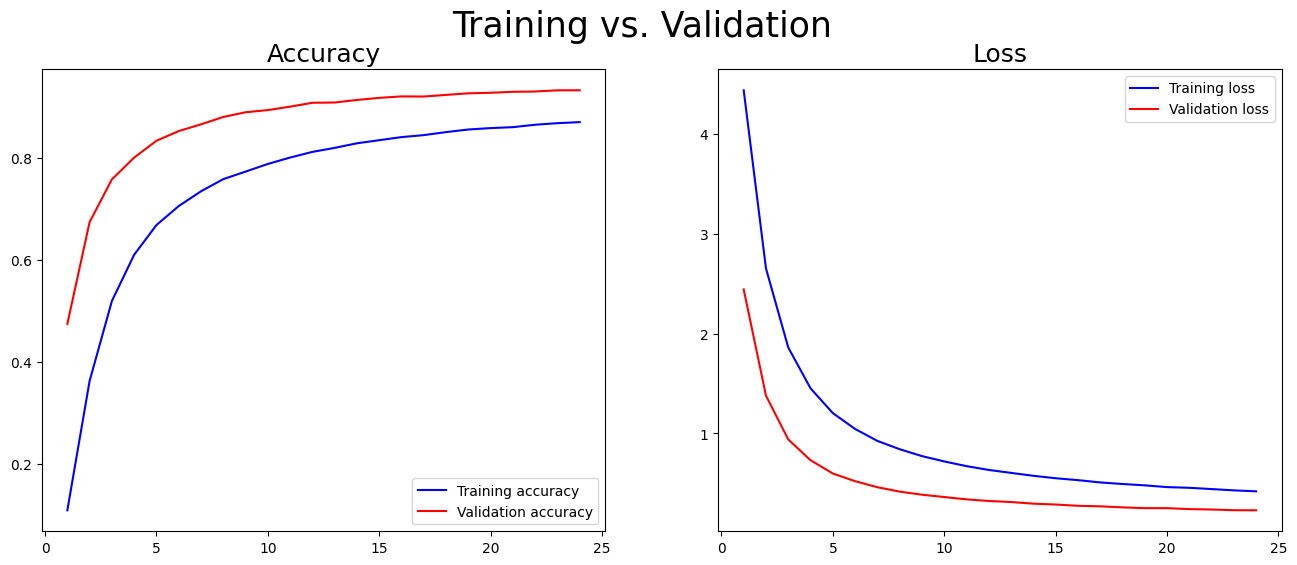

In [22]:
show_training_performance(history)

---

### Prediction

In [ ]:
label_map = {v: k for k, v in train_generator.class_indices.items()}

# df_lbl_map = pd.DataFrame(label_map.values(), index=label_map.keys())
# df_lbl_map.to_csv('label_map.csv')

In [44]:
CLASS_MAP = {
    0: 'ா',
    1: 'அ',
    2: 'ஆ',
    3: 'இ',
    4: 'ஈ',
    5: 'உ',
    6: 'ஊ',
    7: 'எ',
    8: 'ஏ',
    9: 'ஐ',
    10: 'ஒ',
    11: 'ஓ',
    12: 'ஔ',
    13: 'ஃ',
    14: 'க்',
    15: 'க',
    16: 'கி',
    17: 'கீ',
    18: 'கு',
    19: 'கூ',
    20: 'ச்',
    21: 'ச',
    22: 'சி',
    23: 'சீ',
    24: 'சு',
    25: 'சூ',
    26: 'ங்',
    27: 'ங',
    28: 'ஙி',
    29: 'ஙீ',
    30: 'ஙு',
    31: 'ஙூ',
    32: 'ஞ்',
    33: 'ஞ',
    34: 'ஞி',
    35: 'ஞீ',
    36: 'ஞு',
    37: 'ஞூ',
    38: 'ட்',
    39: 'ட',
    40: 'டி',
    41: 'டீ',
    42: 'டு',
    43: 'டூ',
    44: 'ண்',
    45: 'ண',
    46: 'ணி',
    47: 'ணீ',
    48: 'ணு',
    49: 'ணூ',
    50: 'த்',
    51: 'த',
    52: 'தி',
    53: 'தீ',
    54: 'து',
    55: 'தூ',
    56: 'ந்',
    57: 'ந',
    58: 'நி',
    59: 'நீ',
    60: 'நு',
    61: 'நூ',
    62: 'ப்',
    63: 'ப',
    64: 'பி',
    65: 'பீ',
    66: 'பு',
    67: 'பூ',
    68: 'ம்',
    69: 'ம',
    70: 'மி',
    71: 'மீ',
    72: 'மு',
    73: 'மூ',
    74: 'ய்',
    75: 'ய',
    76: 'யி',
    77: 'யீ',
    78: 'யு',
    79: 'யூ',
    80: 'ர்',
    81: 'ர',
    82: 'ரி',
    83: 'ரீ',
    84: 'ரு',
    85: 'ரூ',
    86: 'ல்',
    87: 'ல',
    88: 'லி',
    89: 'லீ',
    90: 'லு',
    91: 'லூ',
    92: 'ள்',
    93: 'ள',
    94: 'ளி',
    95: 'ளீ',
    96: 'ளு',
    97: 'ளூ ',
    98: 'ற்',
    99: 'ற',
    100: 'றி',
    101: 'றீ',
    102: 'று',
    103: 'றூ ',
    104: 'வ்',
    105: 'வ',
    106: 'வி',
    107: 'வீ',
    108: 'வு',
    109: 'வூ ',
    110: 'ழ்',
    111: 'ழ',
    112: 'ழி',
    113: 'ழீ',
    114: 'ழு',
    115: 'ழூ ',
    116: 'ன்',
    117: 'ன',
    118: 'னி',
    119: 'னீ',
    120: 'னு',
    121: 'ஷி',
    122: 'ஷீ',
    123: 'ஷு',
    124: 'ஷூ',
    125: 'க்ஷ',
    126: 'க்ஷ்',
    127: 'க்ஷி',
    128: 'க்ஷீ',
    129: 'ஜு',
    130: 'ஜூ',
    131: 'ஹ',
    132: 'ஹ்',
    133: 'ஹி',
    134: 'ஹீ',
    135: 'ஹு',
    136: 'ஹூ',
    137: 'ஸ',
    138: 'ஸ்',
    139: 'ஸி',
    140: 'ஸீ',
    141: 'ஸு',
    142: 'ஸூ',
    143: 'ஷ',
    144: 'ஷ்',
    145: 'னூ',
    146: 'ஸ்ரீ',
    147: 'க்ஷூ ',
    148: 'ஜ',
    149: 'ஜ்',
    150: 'ஜி',
    151: 'ஜீ',
    152: 'க்ஷு',
    153: 'ெ',
    154: 'ே',
    155: 'ை'
}

In [51]:
def predict(test_img_path, label_map=label_map):
    image = load_img(test_img_path, color_mode='grayscale', target_size=target_size)

    # Convert the image to a numpy array and scale the pixel values
    image_array = img_to_array(image) / 255.0

    # Add an extra dimension to the array to represent the batch size
    # The model expects a batch of images as input, even if you're only predicting one
    image_array = np.expand_dims(image_array, axis=0)

    # Predict the class of the image
    predictions = base_model.predict(image_array, verbose=0)

    # Assuming your model outputs probabilities for each class, 
    # you can determine the most likely class like this:
    predicted_class = np.argmax(predictions, axis=1)

    predicted_label_name = label_map[predicted_class[0]]

    return predicted_label_name

In [84]:
def predict_and_display(test_img_path, label_map=label_map):
    predicted_label_name = predict(test_img_path, label_map)
    print(f"Predicted character: {CLASS_MAP.get(int(predicted_label_name), '')} \t class: {predicted_label_name}")
    image = load_img(test_img_path, color_mode='grayscale', target_size=target_size)
    display(image)

Predicted character: கு 	 class: 18


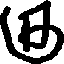

Predicted character: ஒ 	 class: 10


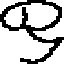

Predicted character: தி 	 class: 52


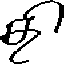

Predicted character: ம 	 class: 69


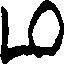

Predicted character: னூ 	 class: 145


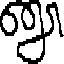

Predicted character: ே 	 class: 154


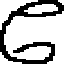

Predicted character: ப 	 class: 63


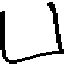

Predicted character: ா 	 class: 0


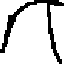

Predicted character: ரி 	 class: 82


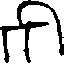

Predicted character: ல் 	 class: 86


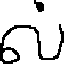

In [85]:
test_images = [
    os.path.join(test_data_dir, '18', '91s_018.bmp'),
    os.path.join(test_data_dir, '10', '80s_010.bmp'),
    os.path.join(test_data_dir, '52', '69s_052.bmp'),
    os.path.join(test_data_dir, '69', '0313_069.bmp'),
    os.path.join(test_data_dir, '145', '9s_145.bmp'),
    os.path.join(test_data_dir, '154', '91s_154.bmp'),
    os.path.join(test_data_dir, '63', '80s_063.bmp'),
    os.path.join(test_data_dir, '0', '72s_000.bmp'),
    os.path.join(test_data_dir, '82', '0340_082.bmp'),
    os.path.join(test_data_dir, '86', '70s_086.bmp'),
]

for img in test_images:
    predict_and_display(img, label_map)

### Statistical Analysis

In [60]:
print(len(test_images))

10


In [67]:
[predict(img) for img in test_images]

['18', '10', '52', '69', '145', '154', '63', '0', '82', '86']

In [68]:
%%timeit
[predict(img) for img in test_images]

646 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
avg_time_per_character = 646 / len(test_images)
print(f'The HCRT model for character identification is taking {avg_time_per_character} ms for a character')

The HCRT model for character identification is taking 64.6 ms for a character


In [71]:
# The approximate characters per line is 30 and lines per page in the legal documents is 20
characters_per_page = 30 * 20

In [73]:
# The sample number of pages and time taken (in mins) for manually transcribed document
manually_transcribed = [
    ('Document 1', 16, 180),
    ('Document 2', 20, 240),
    ('Document 3', 19, 250),
    ('Document 4', 32, 300)
]
manual_df = pd.DataFrame(manually_transcribed, columns=['doc_name', 'pages', 'time_taken'])

In [78]:
manual_df['model_time_taken'] = manual_df['pages'] * characters_per_page * avg_time_per_character / (60 * 1000)
manual_df

,doc_name,pages,time_taken,model_time_taken
0,Document 1,16,180,10.336
1,Document 2,20,240,12.920
2,Document 3,19,250,12.274
3,Document 4,32,300,20.672


### Paired t-test

In [79]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(manual_df['time_taken'], manual_df['model_time_taken'])

print(f'T-Statistic:\t{t_stat}')
print(f'P-Value:\t{p_value}')

T-Statistic:	10.105775422977795
P-Value:	0.0020637678772826924


### Hypothesis Evaluation

In [80]:
if p_value < 0.05:
    print('Null hypothesis is rejected.\nThe HCRT model significantly reduces the transcription time.')
else:
    print('Unable to reject the Null hypothesis.\nThe HCRT model does not significantly reduce the transcription time.')

Null hypothesis is rejected.
The HCRT model significantly reduces the transcription time.


---

In [92]:
base_model.save(f'./models/final/model_with_uthcd_checkpoint.h5', save_format='tf')
base_model.save_weights(f'./models/final/model_with_uthcd_weights.ckpt')
